In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yfinance as yf
import datetime
import mplfinance as mplf
import plotly.graph_objects as go
import scipy.stats as stats
import pylab
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [188]:
#określenie początkowej i końcowej daty
startDate = datetime.datetime(2022, 1, 1)
endDate = datetime.datetime(2023, 1, 1)
#pobranie danych z yahoo finance (cena otwarcia, zamknięcia, najwyższa, najniższa)
data = yf.Ticker("META").history(start=startDate, end=endDate, interval="1d")[['Open', 'Close', 'High', 'Low']]
#obliczanie logarytmicznych stóp zwrotu
data['log_returns'] = np.log(data['Close']) - np.log(data['Close']).shift(-1)
data['log_returns'] = data['log_returns'].dropna()
data['loses'] = np.where(data['log_returns'] < 0, data['log_returns'], 0)
data['loses'] = -1*data['loses']
data.dropna(inplace=True)

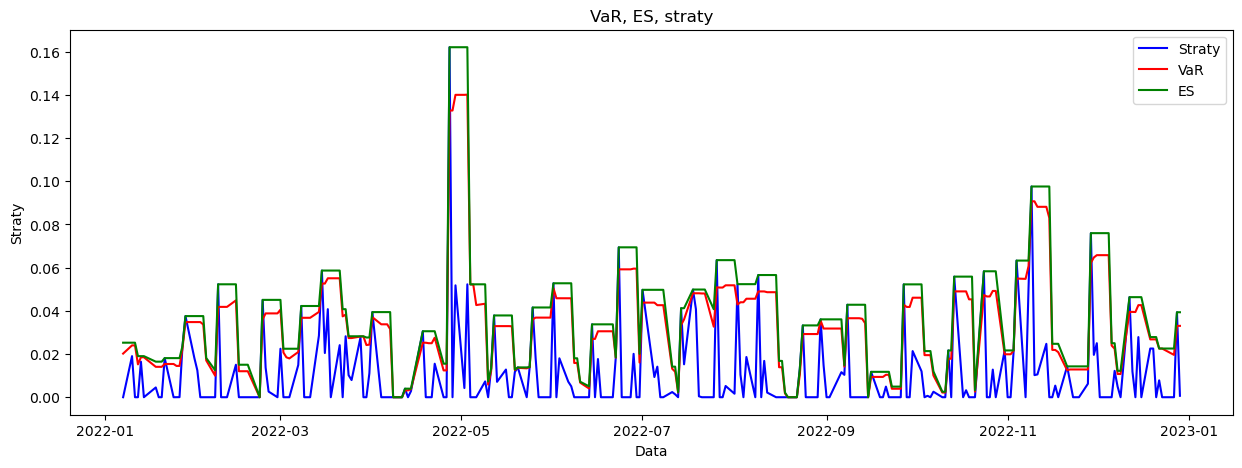

In [189]:
#obliczanie VaR metodą historyczną
#określenie poziomu ufności
alpha = 0.95
#obliczenie kwantyli co 5 dni dla danego poziomu ufności
data["VaR"] = data["loses"].rolling(5).quantile(alpha)
data["ES"] = data["loses"].rolling(5).apply(lambda x: x[x >= x.quantile(alpha)].mean())
data.dropna(inplace=True)
#przedstawienie VaRu, ES i stóp zwrotu na wykresie
fig = plt.figure(figsize=(15, 5))
plt.plot(data["loses"],color="blue")
plt.plot(data["VaR"],color="red",linestyle="-")
plt.plot(data["ES"],color="green",linestyle="-")
plt.xlabel('Data')
plt.ylabel('Straty')
plt.title('VaR, ES, straty')
plt.legend(['Straty','VaR',"ES"])
plt.show()

In [196]:
# Porównanie rozkładu strat i VaR testem Kolmogorova-Smirnova
ks_statistic, p_value = stats.kstest(data['loses'] - data['VaR'], 'norm')

if p_value < 0.05:
    print("Rozkład strat i VaR jest istotnie różny.")
else:
    print("Rozkład strat i VaR nie jest istotnie różny.")


Rozkład strat i VaR nie jest istotnie różny.


In [190]:
#Porównanie VaRu i ES do realnych stóp zwrotu
data['exceeds_VaR'] = data['loses'] > data['VaR']
data['exceeds_ES'] = data['loses'] > data['ES']

#Obliczenie liczby dni, w których VaR został przekroczony
num_exceedances = data['exceeds_VaR'].sum()
num_exceedances2 = data['exceeds_ES'].sum()

#Obliczenie stosunku przekroczeń do wszystkich obserwacji
exceedance_ratio = num_exceedances / len(data)
exceedance2 = num_exceedances2 / len(data)

print(f"Liczba przekroczeń VaR: {num_exceedances}")
print(f"Stosunek przekroczeń VaR: {exceedance_ratio*100:.2f}%")
print(f"Liczba przekroczeń ES: {num_exceedances2}")
print(f"Stosunek przekroczeń ES: {exceedance2*100:.2f}%")

Liczba przekroczeń VaR: 42
Stosunek przekroczeń VaR: 17.07%
Liczba przekroczeń ES: 0
Stosunek przekroczeń ES: 0.00%


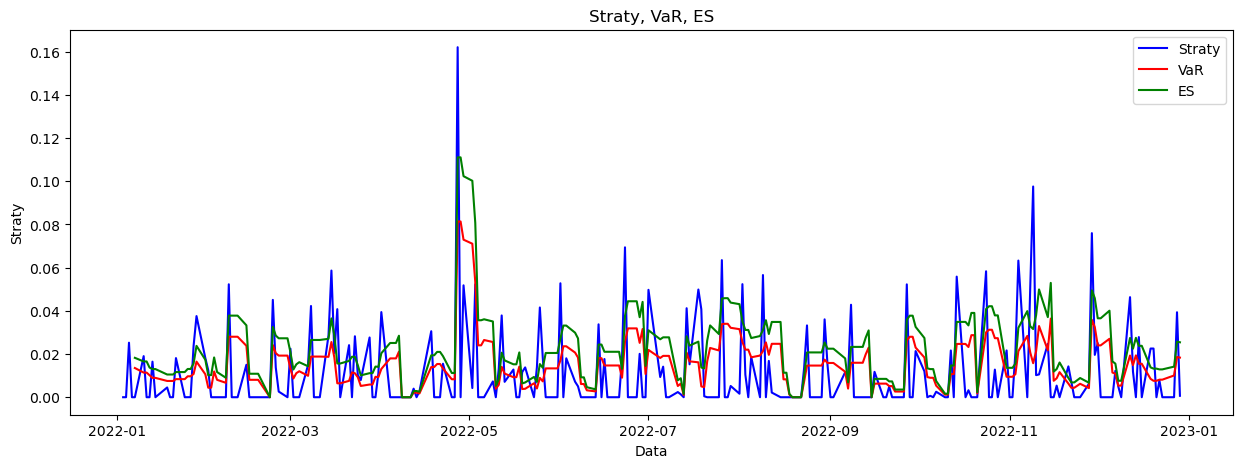

In [191]:
#określenie początkowej i końcowej daty
startDate = datetime.datetime(2022, 1, 1)
endDate = datetime.datetime(2023, 1, 1)
#pobranie danych z yahoo finance (cena otwarcia, zamknięcia, najwyższa, najniższa)
data = yf.Ticker("META").history(start=startDate, end=endDate, interval="1d")[['Open', 'Close', 'High', 'Low']]
#obliczanie logarytmicznych stóp zwrotu
data['log_returns'] = np.log(data['Close']) - np.log(data['Close']).shift(-1)
data['loses'] = -np.where(data['log_returns'] < 0, data['log_returns'], 0)
data.dropna(inplace=True)

#obliczanie VaR i ES metodą parametryczną
alpha = 0.95
z_score = stats.norm.ppf(1 - alpha) 
data['VaR'] = -(data['loses'].rolling(5).mean() + z_score*data["loses"].rolling(5).std())
data['ES'] = -(data['loses'].rolling(5).mean() - (stats.norm.pdf(stats.norm.ppf(1 - alpha)) / (1 - alpha)) * data["loses"].rolling(5).std())

fig = plt.figure(figsize=(15, 5))
plt.plot(data["loses"],color="blue")
plt.plot(data["VaR"],color="red",linestyle="-")
plt.plot(data["ES"],color="green",linestyle="-")
plt.xlabel('Data')
plt.ylabel('Straty')
plt.title('Straty, VaR, ES')
plt.legend(['Straty', 'VaR', 'ES'])
plt.show()


In [197]:
# Porównanie rozkładu strat i VaR testem Kolmogorova-Smirnova
ks_statistic, p_value = stats.kstest(data['loses'] - data['VaR'], 'norm')

if p_value < 0.05:
    print("Rozkład strat i VaR jest istotnie różny.")
else:
    print("Rozkład strat i VaR nie jest istotnie różny.")

Rozkład strat i VaR nie jest istotnie różny.


In [192]:
#Porównanie VaRu i ES do realnych stóp zwrotu
data['exceeds_VaR'] = data['loses'] > data['VaR']
data['exceeds_ES'] = data['loses'] > data['ES']

#Obliczenie liczby dni, w których VaR został przekroczony
num_exceedances = data['exceeds_VaR'].sum()
num_exceedances2 = data['exceeds_ES'].sum()

#Obliczenie stosunku przekroczeń do wszystkich obserwacji
exceedance_ratio = num_exceedances / len(data)
exceedance2 = num_exceedances2 / len(data)

print(f"Liczba przekroczeń VaR: {num_exceedances}")
print(f"Stosunek przekroczeń VaR: {exceedance_ratio*100:.2f}%")
print(f"Liczba przekroczeń ES: {num_exceedances2}")
print(f"Stosunek przekroczeń ES: {exceedance2*100:.2f}%")

Liczba przekroczeń VaR: 76
Stosunek przekroczeń VaR: 30.40%
Liczba przekroczeń ES: 64
Stosunek przekroczeń ES: 25.60%
